In [6]:
import numpy as np
import astropy.units as u
from astropy.io import fits

from gmagaox import utils
from gmagaox.imshows import *

In [34]:
dm2k_fpath = 'gmagaox/data/magaox_2K_best_full_flat_zygo.fits'
data = fits.getdata(dm2k_fpath)
n = data.shape[0]
data[247:297, 480:530] = data[311:361, 480:530]
surf_info = fits.getheader(dm2k_fpath)
display(surf_info)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  628                                                  
NAXIS2  =                  628                                                  
EXTEND  =                    T                                                  

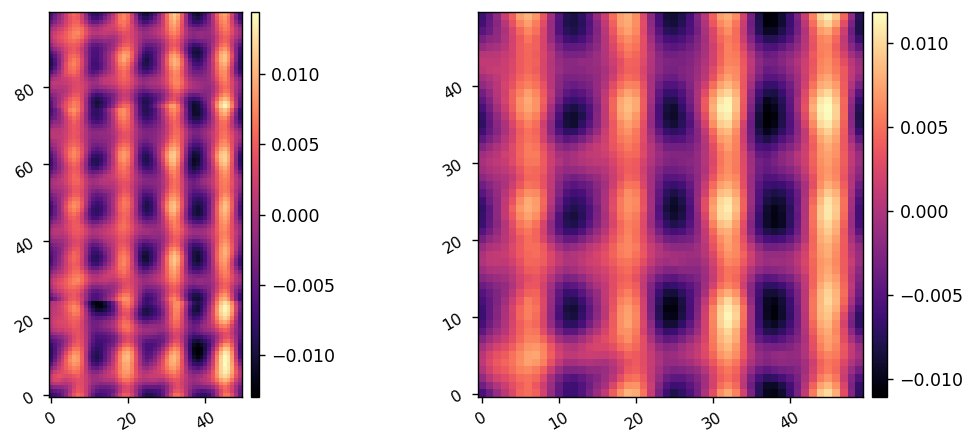

In [31]:
imshow2(data[222:322, 480:530], data[311:361, 480:530])

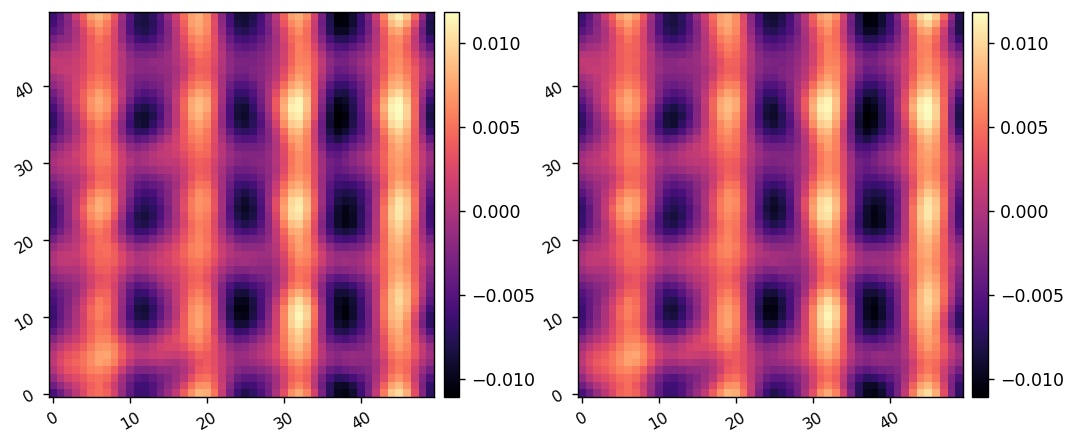

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
imshow2(data[247:297, 480:530], data[311:361, 480:530])
data

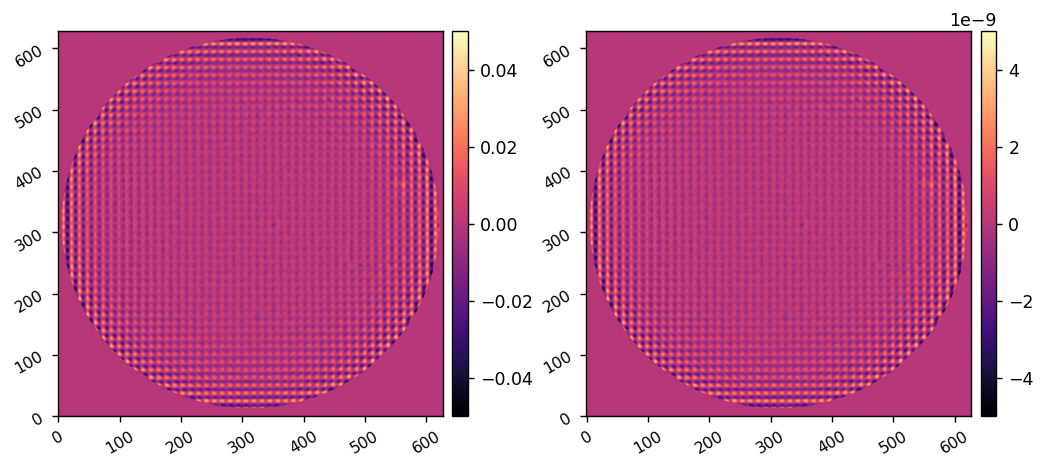

In [29]:
wavelength = 633*u.nm
surf = data * wavelength.to_value(u.m)/(2*np.pi)

imshow2(data, surf, vmin1=-0.05, vmax1=0.05, vmin2=-5e-9, vmax2=5e-9)

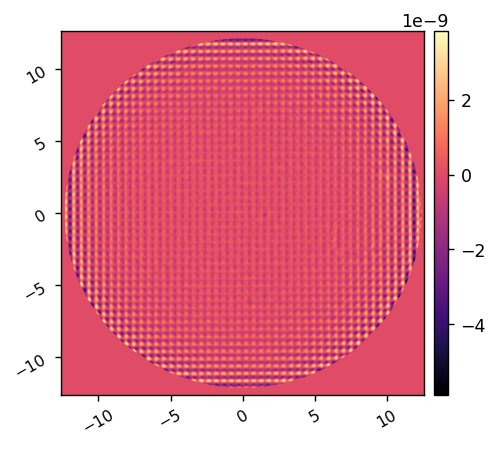

Saved data to:  gmagaox/data/ncp_opds.fits


In [37]:
ncp_pupil_diam = 23.9511421127869*u.mm
pxscl = ncp_pupil_diam/0.95 / (n*u.pix)
ncp_opd = surf
imshow1(surf, pxscl=pxscl)
utils.save_fits('gmagaox/data/ncp_opds.fits', ncp_opd, header={'PIXELSCL':pxscl.to_value(u.m/u.pix)})

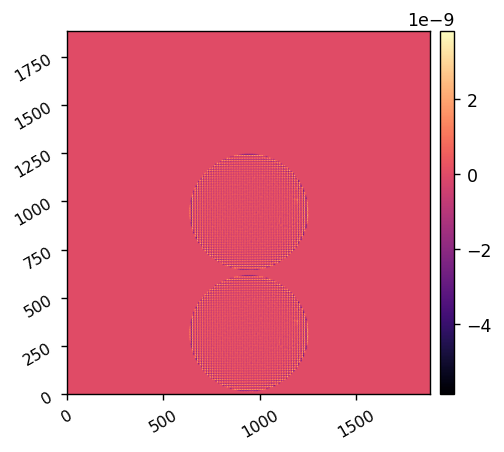

In [40]:
nt = int(3*n)
tweeter_opd = np.zeros((nt, nt))

# center coordinates
ccs = [
    (nt//2,nt//2), 
    (n//2,nt//2),
    
] 

for i in range(len(ccs)):
    tweeter_opd[ccs[i][0]-n//2:ccs[i][0]+n//2, ccs[i][1]-n//2:ccs[i][1]+n//2,] = surf

imshow1(tweeter_opd)


In [ ]:
ncp_pupil_diam = 23.9511421127869*u.mm # acquired from Fresnel propagation
ncp_opd = surf

utils.save_fits('ncp_opds.fits', ncp_opd, header={'PIXELSCL':pxscl.to_value(u.m/u.pix)})